Things to change:
1. Channel generation is an issue, fix it or look up new sum of sinusoid ways
2. Training of AR is an issue, I am training it only on very few samples. AR of order 25 or so is good
3. Train your AR on all the channels estimated so far successfully. 
4. When you are doing the estimation, do this - first send your channel packets, and estimate h over the headers, and then use the channels estimated for training the AR model. 
5. Use MSE over the AR predicted channel and the actual channel from sum of sinusoids
6. Do the entire process pointwise, to have a more microscopic idea of the channels and prediction
7. Do MSE for each point separately, do not keep adding the errors up
8. Plots of threshold value for 4-5 different Doppler frequency, varying threshold of MSE from 0.01 to 0.1

Doubts:
1. Against what do we take the MSE calculation
2. Total least squares

1. Change the initial value
2. Normalize x axis to get the Fd/Fs, 1/Coherence time
3. Check the resolution of the y axis, and where it plateaus. 

4. Plot of the BER and the MSE with this, comapred to the waterfall plot. 
5. Need to decide the optimal MSE and prediction length based on the BER. I want 1e-3 and see the MSE for this BER to occur. 
The blocks with independent SNR are different. MSE 1e-2 to 1e-1
6. Normalize everything, your doppler is with respect to sampling frequency 

1. Normalize
2. BER for BPSK and 16-QAM
Maximum Likelihood - minimum distance decoder. 
3. At a BER we want, fix MSE. 
4. Fix this MSE and get the retransmission vs doppler freq plot for this MSE at different SNR. 


# Channel Generation

In [10]:
import numpy as np
from numpy.linalg import lstsq
from statsmodels.tsa.ar_model import AutoReg
import math
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [11]:
def generate_jakes_channel(Fs, Fd, N):
    """
    Generate a single Rayleigh faded channel with Jakes' Doppler spectrum
    using the improved sum-of-sinusoids method
    
    Parameters:
    Fs : float
        Sampling frequency in Hz
    Fd : float
        Maximum Doppler frequency in Hz
    N : int
        Number of samples to generate
        
    Returns:
    numpy.ndarray
        Complex channel coefficients with proper Bessel function autocorrelation
    """
    # Number of oscillators (should be large enough for good statistics)
    N_osc = 100  # Increased from 8
    
    # Time vector
    t = np.arange(N) / Fs
    
    # Initialize quadrature components
    x_c = np.zeros(N)
    x_s = np.zeros(N)
    
    # Calculate angles for the oscillators (modified for improved statistics)
    beta = np.pi * (np.arange(1, N_osc + 1) - 0.5) / (4 * N_osc)
    
    # Generate random initial phases
    phi_n = np.random.uniform(0, 2*np.pi, N_osc)
    psi_n = np.random.uniform(0, 2*np.pi, N_osc)
    
    # Sum up the oscillators using the improved method
    for n in range(N_osc):
        omega_n = 2 * np.pi * Fd * np.cos(beta[n])
        
        # Modified amplitude coefficients
        amplitude = np.sqrt(2.0 / N_osc)
        
        # In-phase and quadrature components
        x_c += amplitude * np.cos(phi_n[n]) * np.cos(omega_n * t)
        x_s += amplitude * np.cos(psi_n[n]) * np.sin(omega_n * t)
    
    # Combine to form complex channel
    h = x_c + 1j*x_s
    
    return h

In [12]:
def compute_autocorr(x, normalize=True):
    """
    Compute the autocorrelation of a complex signal using FFT method
    """
    N = len(x)
    # Remove mean
    x = x - np.mean(x)
    
    # Compute autocorrelation using FFT
    X = np.fft.fft(x, n=2*N)
    S = X * np.conj(X)
    r = np.fft.ifft(S)
    r = np.real(r[:N])  # Take only the first N points
    
    if normalize:
        r = r / r[0]  # Normalize by the first value
    
    return r

In [16]:
# Example parameters
Fs = 10000  # Sampling frequency
Fd = 100     # Doppler frequency
N = 100000   # Number of samples

# Generate channel
channel = generate_jakes_channel(Fs, Fd, N)

# Compute autocorrelation of the complex channel
autocorr_complex = compute_autocorr(channel)

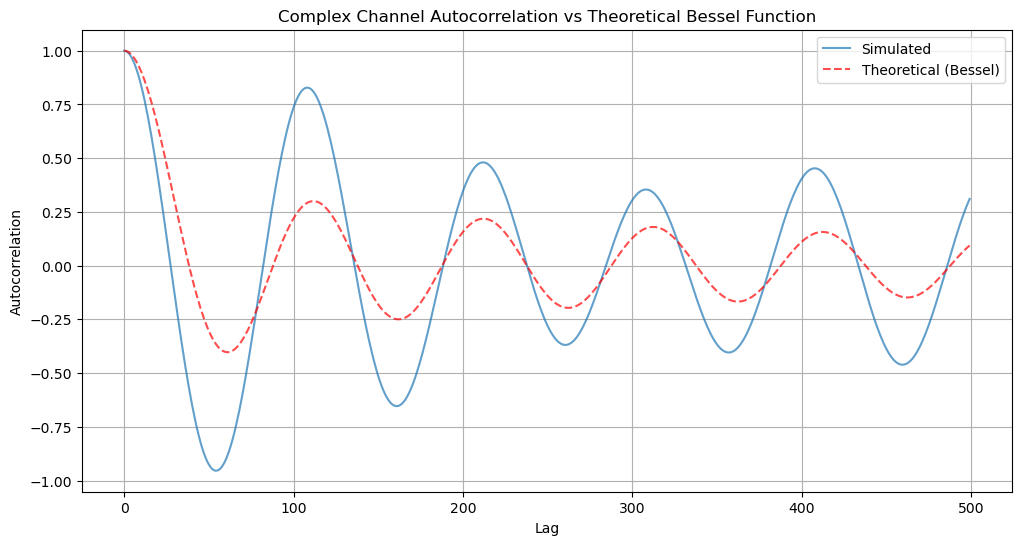

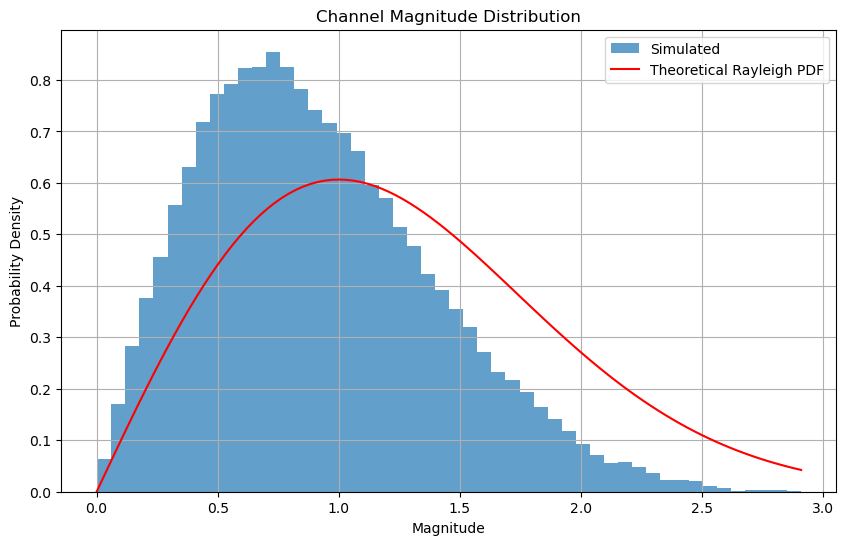

In [18]:
# Generate theoretical Bessel function
lags = np.arange(len(autocorr_complex))
tau = lags / Fs
bessel = jv(0, 2 * np.pi * Fd * tau)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(lags[:500], autocorr_complex[:500], label='Simulated', alpha=0.7)
plt.plot(lags[:500], bessel[:500], 'r--', label='Theoretical (Bessel)', alpha=0.7)
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Complex Channel Autocorrelation vs Theoretical Bessel Function')
plt.legend()
plt.show()

# Additional verification: Plot magnitude distribution
plt.figure(figsize=(10, 6))
plt.hist(np.abs(channel), bins=50, density=True, alpha=0.7, label='Simulated')
r = np.linspace(0, np.max(np.abs(channel)), 100)
rayleigh_pdf = r * np.exp(-r**2/2)
plt.plot(r, rayleigh_pdf, 'r-', label='Theoretical Rayleigh PDF')
plt.grid(True)
plt.xlabel('Magnitude')
plt.ylabel('Probability Density')
plt.title('Channel Magnitude Distribution')
plt.legend()
plt.show()


# Generating Sequence of Noisy Points

In [12]:
def generate_bpsk_signal(N):
    """Generate BPSK signal"""
    return 2 * np.random.randint(0, 2, N) - 1

def add_noise(signal, snr_db):
    """Add complex Gaussian noise to signal"""
    snr_linear = 10 ** (snr_db / 10)
    signal_power = np.mean(np.abs(signal) ** 2)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (
        np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape)
    )
    return signal + noise

def estimate_channel(y, x):
    """Estimate channel coefficient using least squares"""
    return y / x

def moving_average(data, window=3):
    """Apply moving average smoothing"""
    return np.convolve(data, np.ones(window)/window, mode='valid')

def train_ar_models(h_values, ar_order):
    """Train separate AR models for magnitude and phase with preprocessing"""
    # Convert to numpy array if not already
    h_values = np.array(h_values)
    
    # Extract magnitude and phase
    magnitudes = np.abs(h_values)
    phases = np.unwrap(np.angle(h_values))  # Use unwrapped phase for better prediction
    
    # Apply moving average to reduce noise
    if len(magnitudes) > 3:
        magnitudes = moving_average(magnitudes)
        phases = moving_average(phases)
    
    # Train models with adjusted parameters
    mag_model = AutoReg(magnitudes, ar_order, trend='c').fit()
    phase_model = AutoReg(phases, ar_order, trend='c').fit()
    
    return mag_model, phase_model

def predict_channel(mag_model, phase_model, h_history):
    """Predict next channel coefficient using AR models with enhanced prediction"""
    # Get recent history
    recent_mags = np.abs(h_history)
    recent_phases = np.unwrap(np.angle(h_history))
    
    # Make predictions
    mag_pred = mag_model.predict(start=len(recent_mags)-1, end=len(recent_mags)-1)[0]
    phase_pred = phase_model.predict(start=len(recent_phases)-1, end=len(recent_phases)-1)[0]
    
    # Ensure magnitude is positive
    mag_pred = np.abs(mag_pred)
    
    return mag_pred * np.exp(1j * phase_pred)

def simulate_prediction(N, Fs, Fd, snr_db, ar_order, mse_threshold):
    """Simulate channel prediction with improved parameters"""
    # Generate signals
    x = generate_bpsk_signal(N)
    h = generate_jakes_channel(Fs, Fd/10, N)
    y = add_noise(x * h, snr_db)
    
    # Increase header length for better initial estimation
    header_length = 50  # Adaptive header length based on Doppler
    idx = 0
    segment_lengths = []
    total_headers = 0
    
    while idx < N - header_length:
        # Process header segment
        h_estimates = []
        for i in range(header_length):
            h_est = estimate_channel(y[idx + i], x[idx + i])
            h_estimates.append(h_est)
        
        total_headers += header_length
        idx += header_length
        
        # Train AR models
        mag_model, phase_model = train_ar_models(h_estimates, ar_order)
        
        # Prediction phase
        segment_length = 0
        prediction_window = []  # Store recent predictions for averaging
        
        while idx < N:
            h_pred = predict_channel(mag_model, phase_model, h_estimates)
            h_actual = h[idx]
            
            # Calculate MSE with adaptive threshold
            base_mse = np.abs(h_pred - h_actual) ** 2
            
            # Adjust threshold based on Doppler frequency
            adaptive_threshold = mse_threshold
            
            if base_mse > adaptive_threshold:
                break
                
            h_est = estimate_channel(y[idx], x[idx])
            h_estimates.append(h_est)
            
            # Retrain models less frequently but with more recent data
            if len(h_estimates) % 5 == 0:
                # Use more recent samples for retraining
                recent_samples = min(50, len(h_estimates))
                mag_model, phase_model = train_ar_models(h_estimates[-recent_samples:], ar_order)
                
            segment_length += 1
            idx += 1
            
        segment_lengths.append(segment_length)
    
    retrans_freq = total_headers / (total_headers + sum(segment_lengths))
    avg_segment_length = np.mean(segment_lengths)
    
    return retrans_freq, avg_segment_length, segment_lengths

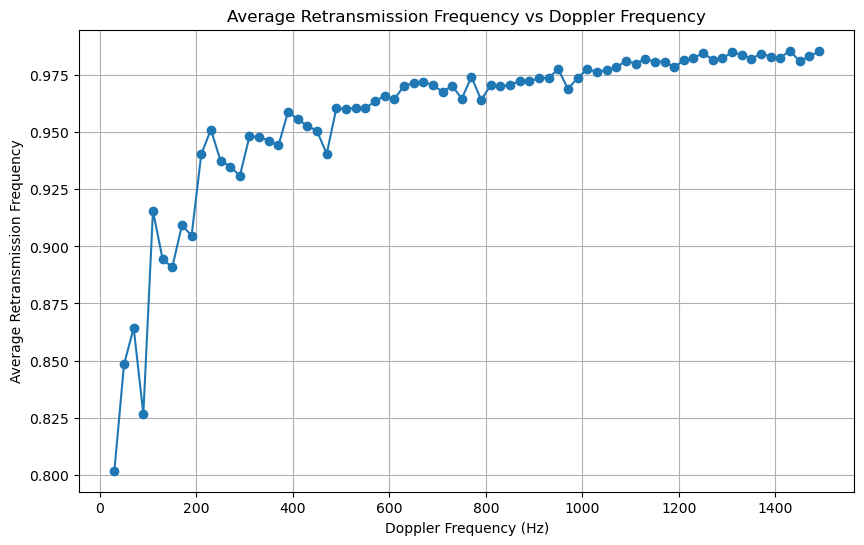

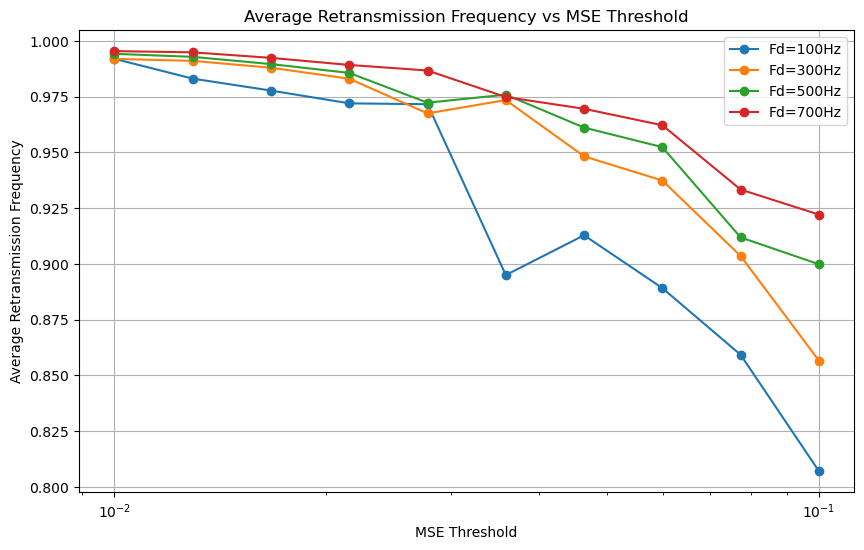

In [14]:
def plot_results(num_repeats=5):
    """Generate plots with improved parameters"""
    N = 10000  # Increased sample size
    Fs = 10000
    snr_db = 10
    ar_order = 15   
    # Plot 1: Retransmission frequency vs Doppler
    doppler_range = np.arange(30, 1501, 20)
    retrans_freqs_avg = []

    for Fd in doppler_range:
        retrans_freqs = []
        for _ in range(num_repeats):
            # Adjust threshold based on Doppler
            base_threshold = 0.05
            retrans_freq, avg_len, _ = simulate_prediction(
                N, Fs, Fd, snr_db, ar_order, base_threshold
            )
            retrans_freqs.append(retrans_freq)

        # Calculate the average retransmission frequency for the current Doppler
        retrans_freqs_avg.append(np.mean(retrans_freqs))
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_range, retrans_freqs_avg, 'o-')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Retransmission Frequency')
    plt.title('Average Retransmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()
    
    # Plot 2: Retransmission frequency vs Threshold
    selected_dopplers = [100, 300, 500, 700]
    thresholds = np.logspace(-2, -1, 10)
    
    plt.figure(figsize=(10, 6))
    for Fd in selected_dopplers:
        retrans_freqs_avg = []
        for threshold in thresholds:
            retrans_freqs = []
            for _ in range(num_repeats):
                retrans_freq, _, _ = simulate_prediction(
                    N, Fs, Fd, snr_db, ar_order, threshold
                )
                retrans_freqs.append(retrans_freq)
            retrans_freqs_avg.append(np.mean(retrans_freqs))
        plt.semilogx(thresholds, retrans_freqs_avg, 'o-', label=f'Fd={Fd}Hz')
    
    plt.xlabel('MSE Threshold')
    plt.ylabel('Average Retransmission Frequency')
    plt.title('Average Retransmission Frequency vs MSE Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_results(num_repeats=5)  # Adjust the number of repeats as needed


In [55]:
# def plot_results2():
#     """Generate plots with improved parameters"""
#     N = 10000  # Increased sample size
#     Fs = 10000
#     snr_db = 10
#     ar_order = 15   
#     # Plot 1: Retransmission frequency vs Doppler
#     doppler_range = np.arange(10, 1501, 20)
#     retrans_freqs = []
    
#     for Fd in doppler_range:
#         # Adjust threshold based on Doppler
#         base_threshold = 0.05
#         retrans_freq, avg_len, _ = simulate_prediction(
#             N, Fs, Fd, snr_db, ar_order, base_threshold
#         )
#         retrans_freqs.append(retrans_freq)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(doppler_range, retrans_freqs, 'o-')
#     plt.xlabel('Doppler Frequency (Hz)')
#     plt.ylabel('Retransmission Frequency')
#     plt.title('Retransmission Frequency vs Doppler Frequency')
#     plt.grid(True)
#     plt.show()
    

# if __name__ == "__main__":
#     plot_results2()

# Total Least Squares

In [57]:
def moving_average(data, window=3):
    """Apply moving average smoothing"""
    return np.convolve(data, np.ones(window) / window, mode='valid')

def total_least_squares(X, y):
    """Estimate AR parameters using Total Least Squares"""
    # Stack X and y to create an augmented matrix
    A = np.column_stack((X, y))
    U, S, Vh = svd(A, full_matrices=False)
    V = Vh.T
    Vxy = V[:-1, -1]  # Last column of V, excluding the last row
    Vyy = V[-1, -1]   # Last element of V
    
    # Calculate AR coefficients (negative to match prediction formulation)
    ar_params = -Vxy / Vyy
    return ar_params

def train_ar_models(h_values, ar_order):
    """Train separate AR models for magnitude and phase using TLS for AR parameter estimation"""
    h_values = np.array(h_values)
    magnitudes = np.abs(h_values)
    phases = np.unwrap(np.angle(h_values))
    
    # Apply moving average to reduce noise
    if len(magnitudes) > 3:
        magnitudes = moving_average(magnitudes)
        phases = moving_average(phases)
    
    # Prepare data matrices for AR modeling
    def ar_data_matrix(data, order):
        X = np.column_stack([data[i:len(data) - order + i] for i in range(order)])
        y = data[order:]
        return X, y
    
    # Magnitude AR model
    X_mag, y_mag = ar_data_matrix(magnitudes, ar_order)
    mag_params = total_least_squares(X_mag, y_mag)
    
    # Phase AR model
    X_phase, y_phase = ar_data_matrix(phases, ar_order)
    phase_params = total_least_squares(X_phase, y_phase)
    
    return mag_params, phase_params

def predict_channel(mag_params, phase_params, h_history, ar_order):
    """Predict next channel coefficient using AR models with TLS-estimated parameters"""
    recent_mags = np.abs(h_history)
    recent_phases = np.unwrap(np.angle(h_history))
    
    # Use AR parameters for prediction
    mag_pred = np.dot(mag_params, recent_mags[-ar_order:])
    phase_pred = np.dot(phase_params, recent_phases[-ar_order:])
    
    mag_pred = np.abs(mag_pred)
    
    return mag_pred * np.exp(1j * phase_pred)

def simulate_prediction_tls(N, Fs, Fd, snr_db, ar_order, mse_threshold):
    """Simulate channel prediction with improved parameters using TLS for AR estimation"""
    x = generate_bpsk_signal(N)
    h = generate_jakes_channel(Fs, Fd / 10, N)
    y = add_noise(x * h, snr_db)
    
    header_length = 50
    idx = 0
    segment_lengths = []
    total_headers = 0
    
    while idx < N - header_length:
        h_estimates = []
        for i in range(header_length):
            h_est = estimate_channel(y[idx + i], x[idx + i])
            h_estimates.append(h_est)
        
        total_headers += header_length
        idx += header_length
        
        mag_params, phase_params = train_ar_models(h_estimates, ar_order)
        
        segment_length = 0
        
        while idx < N:
            h_pred = predict_channel(mag_params, phase_params, h_estimates, ar_order)
            h_actual = h[idx]
            
            base_mse = np.abs(h_pred - h_actual) ** 2
            adaptive_threshold = mse_threshold
            
            if base_mse > adaptive_threshold:
                break
                
            h_est = estimate_channel(y[idx], x[idx])
            h_estimates.append(h_est)
            
            if len(h_estimates) % 20 == 0:
                recent_samples = min(100, len(h_estimates))
                mag_params, phase_params = train_ar_models(h_estimates[-recent_samples:], ar_order)
                
            segment_length += 1
            idx += 1
            
        segment_lengths.append(segment_length)
    
    retrans_freq = total_headers / (total_headers + sum(segment_lengths))
    avg_segment_length = np.mean(segment_lengths)
    
    return retrans_freq, avg_segment_length, segment_lengths

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_retransmission_vs_doppler_tls(num_repeats=10):
    """Plot retransmission frequency vs Doppler frequency using TLS for AR estimation"""
    N = 10000  # Sample size
    Fs = 10000  # Sampling frequency
    snr_db = 10  # Signal-to-noise ratio in dB
    ar_order = 15  # AR model order
    mse_threshold = 0.05  # MSE threshold
    
    # Define the range of Doppler frequencies to analyze
    doppler_range = np.arange(30, 1501, 20)
    retrans_freqs_avg = []  # Store average retransmission frequencies

    # Loop over Doppler frequencies and calculate average retransmission frequency
    for Fd in doppler_range:
        retrans_freqs = []
        
        for _ in range(num_repeats):
            retrans_freq, _, _ = simulate_prediction_tls(N, Fs, Fd, snr_db, ar_order, mse_threshold)
            retrans_freqs.append(retrans_freq)
        
        # Calculate the average retransmission frequency for this Doppler frequency
        retrans_freqs_avg.append(np.mean(retrans_freqs))
    
    # Plotting retransmission frequency vs Doppler frequency
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_range, retrans_freqs_avg, 'o-')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Average Retransmission Frequency')
    plt.title('Average Retransmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_retransmission_vs_doppler(num_repeats=3)  # Adjust repeats as needed


NameError: name 'plot_retransmission_vs_doppler' is not defined

# Robust Estimation Trial

In [ ]:
def train_ar_models_robust(h_values, ar_order):
    """Train separate AR models for magnitude and phase using robust estimation"""
    if len(h_values) <= ar_order + 1:
        raise ValueError("Not enough samples for AR model training")
        
    h_values = np.array(h_values)
    magnitudes = np.abs(h_values)
    phases = np.unwrap(np.angle(h_values))
    
    N = len(magnitudes)
    
    # Ensure we have enough samples
    if N - ar_order < 2:
        raise ValueError("Not enough samples after AR order reduction")
    
    # Prepare data for magnitudes
    Y_mag = magnitudes[ar_order:]
    X_mag = np.column_stack([magnitudes[ar_order - i - 1:N - i - 1] for i in range(ar_order)])
    X_mag = sm.add_constant(X_mag)
    
    # Prepare data for phases
    Y_phase = phases[ar_order:]
    X_phase = np.column_stack([phases[ar_order - i - 1:N - i - 1] for i in range(ar_order)])
    X_phase = sm.add_constant(X_phase)
    
    try:
        # Fit robust linear models with fallback to OLS if RLM fails
        try:
            mag_model = sm.RLM(Y_mag, X_mag, M=sm.robust.norms.HuberT()).fit()
        except:
            mag_model = sm.OLS(Y_mag, X_mag).fit()
            
        try:
            phase_model = sm.RLM(Y_phase, X_phase, M=sm.robust.norms.HuberT()).fit()
        except:
            phase_model = sm.OLS(Y_phase, X_phase).fit()
            
        return mag_model, phase_model
    except Exception as e:
        raise ValueError(f"Model fitting failed: {str(e)}")

def predict_channel(mag_model, phase_model, h_history, ar_order):
    """Predict next channel coefficient using robust AR models"""
    if len(h_history) < ar_order:
        raise ValueError("Not enough history for prediction")
        
    magnitudes = np.abs(h_history)
    phases = np.unwrap(np.angle(h_history))
    
    # Prepare input for prediction
    X_mag_pred = np.array([magnitudes[-i-1] for i in range(ar_order)])
    X_mag_pred = np.insert(X_mag_pred, 0, 1)
    X_phase_pred = np.array([phases[-i-1] for i in range(ar_order)])
    X_phase_pred = np.insert(X_phase_pred, 0, 1)
    
    # Make predictions
    mag_pred = np.clip(np.dot(X_mag_pred, mag_model.params), 0, None)  # Ensure positive magnitude
    phase_pred = np.dot(X_phase_pred, phase_model.params)
    
    return mag_pred * np.exp(1j * phase_pred)


def simulate_prediction(N, Fs, Fd, snr_db, ar_order, mse_threshold):
    """Simulate channel prediction using robust estimation in AR models"""
    x = generate_bpsk_signal(N)
    h = generate_jakes_channel(Fs, Fd, N)  # Assuming this function exists
    y = add_noise(x * h, snr_db)
    
    header_length = max(2 * ar_order, 30)
    idx = 0
    total_headers = 0
    segment_lengths = []
    min_retrain_samples = 2 * ar_order
    
    while idx < N:
        # Transmit header
        h_estimates = []
        for i in range(header_length):
            if idx >= N:
                break
            h_est = estimate_channel(y[idx], x[idx])  # Assuming this function exists
            h_estimates.append(h_est)
            idx += 1
            
        if len(h_estimates) <= ar_order:
            break
            
        total_headers += len(h_estimates)
        
        # Train AR models
        try:
            mag_model, phase_model = train_ar_models_robust(h_estimates, ar_order)
        except ValueError as e:
            print(f"Training failed: {e}")
            break
            
        # Prediction phase
        segment_length = 0
        h_history = h_estimates.copy()
        
        while idx < N:
            try:
                h_pred = predict_channel(mag_model, phase_model, h_history, ar_order)
                h_actual = h[idx]
                mse = np.abs(h_pred - h_actual) ** 2
                
                if mse > mse_threshold:
                    break
                    
                h_est = estimate_channel(y[idx], x[idx])
                h_history.append(h_est)
                idx += 1
                segment_length += 1
                
                # Retrain model periodically
                if len(h_history) >= len(h_estimates) + min_retrain_samples:
                    try:
                        mag_model, phase_model = train_ar_models_robust(h_history[-min_retrain_samples:], ar_order)
                    except ValueError:
                        break
                        
            except Exception as e:
                print(f"Prediction failed: {e}")
                break
                
        if segment_length > 0:
            segment_lengths.append(segment_length)
            
    # Calculate metrics
    total_data_packets = sum(segment_lengths)
    if total_headers + total_data_packets == 0:
        return 1.0, 0, []  # Return maximum retransmission frequency if no successful transmissions
        
    retrans_freq = total_headers / (total_headers + total_data_packets)
    avg_segment_length = np.mean(segment_lengths) if segment_lengths else 0
    
    return retrans_freq, avg_segment_length, segment_lengths


In [ ]:
def plot_results():
    """Generate plots for retransmission frequency vs Doppler frequency and MSE threshold"""
    N = 10000
    Fs = 10000
    snr_db = 10
    ar_order = 15
    mse_threshold = 0.05
    
    # Plot retransmission frequency vs Doppler frequency
    doppler_range = np.arange(10, 801, 100)
    retrans_freqs = []
    
    for Fd in doppler_range:
        try:
            retrans_freq, avg_len, _ = simulate_prediction(N, Fs, Fd, snr_db, ar_order, mse_threshold)
            retrans_freqs.append(retrans_freq)
            print(f"Doppler {Fd} Hz: Retransmission frequency = {retrans_freq:.3f}, Avg segment length = {avg_len:.1f}")
        except Exception as e:
            print(f"Error at Doppler {Fd} Hz: {e}")
            retrans_freqs.append(np.nan)
            
    # Remove any NaN values before plotting
    valid_mask = ~np.isnan(retrans_freqs)
    doppler_plot = doppler_range[valid_mask]
    retrans_plot = np.array(retrans_freqs)[valid_mask]
    
    plt.figure(figsize=(10, 6))
    plt.plot(doppler_plot, retrans_plot, 'o-')
    plt.xlabel('Doppler Frequency (Hz)')
    plt.ylabel('Retransmission Frequency')
    plt.title('Retransmission Frequency vs Doppler Frequency')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    plot_results()